In [1]:
import pandas as pd
# from dataprep.eda import plot
import warnings
from scorecardbundle.feature_discretization import ChiMerge as cm
from scorecardbundle.feature_discretization import FeatureIntervalAdjustment as fia
from scorecardbundle.feature_encoding import WOE as woe
from scorecardbundle.feature_selection import FeatureSelection as fs
from scorecardbundle.model_training import LogisticRegressionScoreCard as lrsc
from scorecardbundle.model_evaluation import ModelEvaluation as me
from sklearn.model_selection import train_test_split


train_data = pd.read_csv(r'D:\书籍资料整理\工作接触的模型\GiveMeSomeCredit\cs-training.csv', index_col=0)
train_data.columns = ['严重违约', '可用额度比例','年龄', '35-69天逾期次数', '负债比例','月收入','普通贷款数量','高于90天逾期次数','不动产贷款数量','60-89天逾期次数','家属数量']
train_data = train_data[['年龄','家属数量','月收入','负债比例','可用额度比例','普通贷款数量','不动产贷款数量','35-69天逾期次数','60-89天逾期次数','高于90天逾期次数','严重违约']]

# 手工探索数据
print(train_data.shape)
print(train_data.isnull().sum()/train_data.shape[0])
print(train_data.describe().T)
print(train_data['严重违约'].value_counts())  #可以看到不均衡
print(train_data['严重违约'].sum()/train_data['严重违约'].count()) #0.06684
# 使用EDA工具探索数据
# plot(train_data)

#先说结论,模型是一个不平衡数据集,并且月收入缺失较严重,家属数量缺失一般.
#示例代码使用了随机森林填充法,这里可以试验下与0填充对比
#随机森林填充法、假设要填充变量与其他值之间有关系
from sklearn.ensemble import RandomForestRegressor


def fill_income_missing(data, to_fill):
    df = data.copy()
    columns = [*df.columns]
    columns.remove(to_fill)

    # 移除有缺失值的列
    columns.remove('家属数量')
    X = df.loc[:, columns]
    y = df.loc[:, to_fill]
    X_train = X.loc[df[to_fill].notnull()]
    y_train = y.loc[df[to_fill].notnull()]
    X_pred = X.loc[df[to_fill].isnull()]
    rfr = RandomForestRegressor(random_state=22, n_estimators=200, max_depth=3, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_pred).round()
    df.loc[df[to_fill].isnull(), to_fill] = y_pred
    return df


def fill_dependents_missing(data, to_fill):
    df = data.copy()
    columns = [*df.columns]
    columns.remove(to_fill)

    X = df.loc[:, columns]
    y = df.loc[:, to_fill]
    X_train = X.loc[df[to_fill].notnull()]
    y_train = y.loc[df[to_fill].notnull()]
    X_pred = X.loc[df[to_fill].isnull()]
    rfr = RandomForestRegressor(random_state=22, n_estimators=200, max_depth=3, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_pred).round()
    df.loc[df[to_fill].isnull(), to_fill] = y_pred
    return df



(150000, 11)
年龄            0.000000
家属数量          0.026160
月收入           0.198207
负债比例          0.000000
可用额度比例        0.000000
普通贷款数量        0.000000
不动产贷款数量       0.000000
35-69天逾期次数    0.000000
60-89天逾期次数    0.000000
高于90天逾期次数     0.000000
严重违约          0.000000
dtype: float64
               count         mean           std  min          25%  \
年龄          150000.0    52.295207     14.771866  0.0    41.000000   
家属数量        146076.0     0.757222      1.115086  0.0     0.000000   
月收入         120269.0  6670.221237  14384.674215  0.0  3400.000000   
负债比例        150000.0   353.005076   2037.818523  0.0     0.175074   
可用额度比例      150000.0     6.048438    249.755371  0.0     0.029867   
普通贷款数量      150000.0     8.452760      5.145951  0.0     5.000000   
不动产贷款数量     150000.0     1.018240      1.129771  0.0     0.000000   
35-69天逾期次数  150000.0     0.421033      4.192781  0.0     0.000000   
60-89天逾期次数  150000.0     0.240387      4.155179  0.0     0.000000   
高于90天逾期次数   150000.0     0.26

年龄            0
家属数量          0
月收入           0
负债比例          0
可用额度比例        0
普通贷款数量        0
不动产贷款数量       0
35-69天逾期次数    0
60-89天逾期次数    0
高于90天逾期次数     0
严重违约          0
dtype: int64


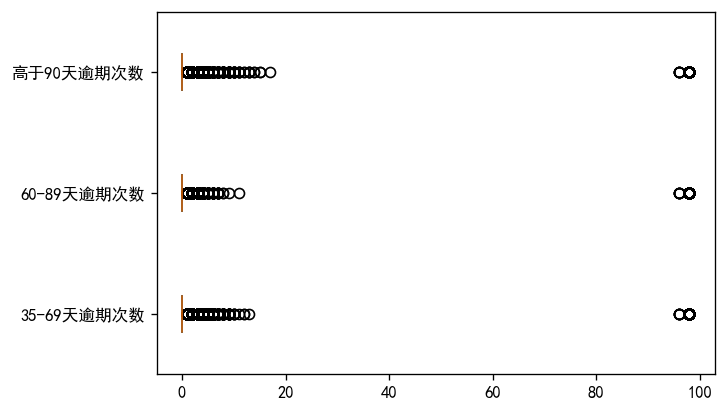

In [2]:
train_data = fill_income_missing(train_data, '月收入')
train_data = fill_dependents_missing(train_data, '家属数量')
print(train_data.isnull().sum())
#删除年龄小于0的数据
train_data = train_data.loc[train_data['年龄'] > 0]
#这里是去除预期数据中的异常值(逾期次数较多的)
columns = ['35-69天逾期次数','60-89天逾期次数','高于90天逾期次数']
train_data.loc[:, columns].plot.box(vert=False)
train_data = train_data[(train_data['35-69天逾期次数'] < 90) & (train_data['60-89天逾期次数'] < 90)  & (train_data['高于90天逾期次数'] < 90)]

In [3]:
X = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

#分箱
trans_cm = cm.ChiMerge(max_intervals=10, min_intervals=5, output_dataframe=True)  #卡分分箱
result_cm = trans_cm.fit_transform(X_train, y_train)


print('特征切分',trans_cm.boundaries_) # 每个特征的区间切分

特征切分 {'年龄': array([22., 33., 43., 53., 56., 62., 67., 69., 74., inf]), '家属数量': array([ 0.,  1.,  2.,  5.,  6., inf]), '月收入': array([ 600., 1144., 2300., 2314., 4995., 5177., 5300., 6666., 9700.,
         inf]), '负债比例': array([0.00000000e+00, 1.05842408e-02, 1.99445173e-01, 3.58516382e-01,
       5.08362821e-01, 7.13690498e-01, 4.00000000e+00, 1.23000000e+02,
       6.39520000e+02,            inf]), '可用额度比例': array([0.        , 0.04049472, 0.11318247, 0.22958469, 0.4022423 ,
       0.60780435, 0.72327142, 0.90512174, 0.9999999 ,        inf]), '普通贷款数量': array([ 0.,  1.,  2.,  3.,  5.,  7.,  8., 14., 15., inf]), '不动产贷款数量': array([ 0.,  2.,  3.,  4.,  5., 10., 11., inf]), '35-69天逾期次数': array([ 0.,  1.,  2.,  3.,  5., inf]), '60-89天逾期次数': array([ 0.,  1.,  2.,  9., inf]), '高于90天逾期次数': array([ 0.,  1.,  2.,  3.,  6., 11., inf])}


In [4]:
#进行WOE编码
trans_woe = woe.WOE_Encoder(output_dataframe=True)
result_woe = trans_woe.fit_transform(result_cm, y_train)
print('每个特征的信息值',trans_woe.iv_) # 每个特征的信息值 (iv)
print('每个特征的WOE字典和信息值',trans_woe.result_dict_) # 每个特征的WOE字典和信息值 (iv)



每个特征的信息值 {'年龄': 0.2701768711929571, '家属数量': 0.03701283169728562, '月收入': 0.1058758118628369, '负债比例': 0.10825877374959453, '可用额度比例': 1.157265036913761, '普通贷款数量': 0.08480560279918845, '不动产贷款数量': 0.06145960106235026, '35-69天逾期次数': 0.71889696408604, '60-89天逾期次数': 0.570989412963136, '高于90天逾期次数': 0.8479811455932114}
每个特征的WOE字典和信息值 {'年龄': ({'-inf~22.0': 0.08614429229224266, '22.0~33.0': 0.5803960150367878, '33.0~43.0': 0.36522238836925824, '43.0~53.0': 0.1733964197785882, '53.0~56.0': -0.03249388841732125, '56.0~62.0': -0.33557570355691463, '62.0~67.0': -0.7308513139747165, '67.0~69.0': -1.3725884898187861, '69.0~74.0': -0.9210088769013128, '74.0~inf': -1.286479101662532}, 0.2701768711929571), '家属数量': ({'-inf~0.0': -0.16007708885701935, '0.0~1.0': 0.10336362281864103, '1.0~2.0': 0.23139431566548224, '2.0~5.0': 0.3345603632952632, '5.0~6.0': 1.0183371770327663, '6.0~inf': 0.2208609404652806}, 0.03701283169728562), '月收入': ({'-inf~600.0': -0.5530404744362006, '1144.0~2300.0': 0.45831463372628983,

In [5]:
#剔除预测力过低（通常用IV不足0.02筛选）、以及相关性过高引起共线性问题的特征。
# (相关性过高的阈值默认为皮尔森相关性系数大于0.6，可通过threshold_corr参数调整)
print(fs.selection_with_iv_corr(trans_woe, result_woe)) # corr_with 列示了与该特征相关性过高的特征和相关系数

#模型训练
model = lrsc.LogisticRegressionScoreCard(trans_woe, PDO=-20, basePoints=100, verbose=True)
model.fit(result_woe, y_train)
print('评分卡规则',model.woe_df_) # 从woe_df_属性中可得评分卡规则

       factor        IV                                           woe_dict  \
4      可用额度比例  1.157265  {'-inf~0.0': -0.7982239915410034, '0.040494719...   
9   高于90天逾期次数  0.847981  {'-inf~0.0': -0.37596547289053783, '0.0~1.0': ...   
7  35-69天逾期次数  0.718897  {'-inf~0.0': -0.5221968129318225, '0.0~1.0': 0...   
8  60-89天逾期次数  0.570989  {'-inf~0.0': -0.27457805724491785, '0.0~1.0': ...   
0          年龄  0.270177  {'-inf~22.0': 0.08614429229224266, '22.0~33.0'...   
3        负债比例  0.108259  {'-inf~0.0': -0.05469389140905446, '0.01058424...   
2         月收入  0.105876  {'-inf~600.0': -0.5530404744362006, '1144.0~23...   
5      普通贷款数量  0.084806  {'-inf~0.0': 1.3119452532908402, '0.0~1.0': 0....   
6     不动产贷款数量  0.061460  {'-inf~0.0': 0.2220297869483822, '0.0~2.0': -0...   
1        家属数量  0.037013  {'-inf~0.0': -0.16007708885701935, '0.0~1.0': ...   

  corr_with  
4        {}  
9        {}  
7        {}  
8        {}  
0        {}  
3        {}  
2        {}  
5        {}  
6        {}  
1

KS = 0.552


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\scorecardbundle\model_evaluation\ModelEvaluation.py:125: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='KS = '+str(ks) ,xy=(diff.abs().idxmax(),diff.abs().max()))


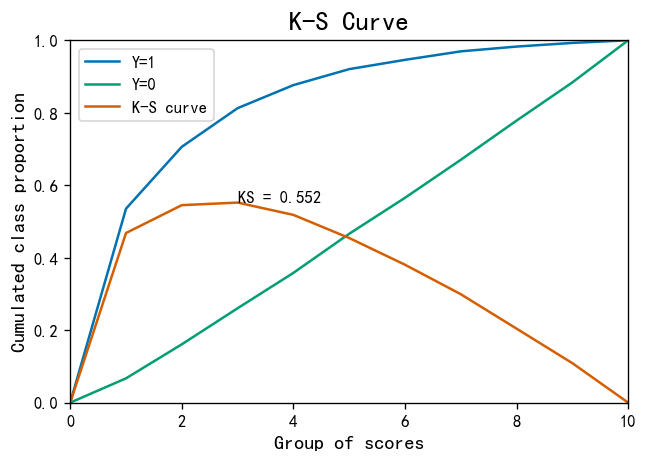

AUC: 0.8577890158171938


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\scorecardbundle\model_evaluation\ModelEvaluation.py:189: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='AUC = '+str(round(roc_auc_score(target, scores),3)),


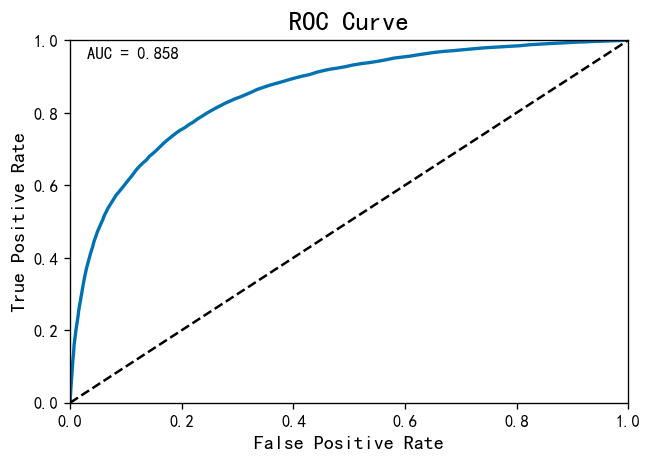

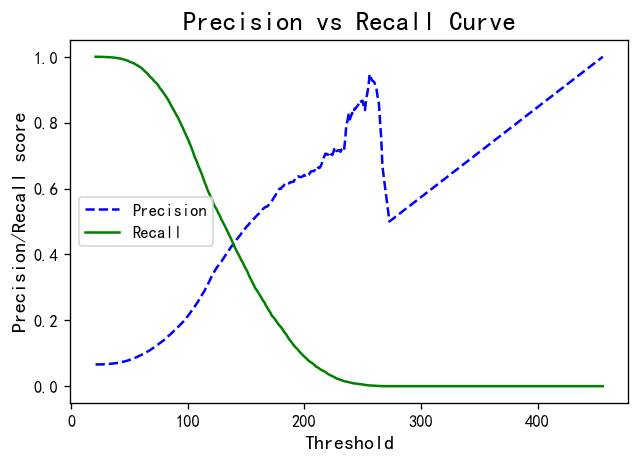

KS = 0.551


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\scorecardbundle\model_evaluation\ModelEvaluation.py:125: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='KS = '+str(ks) ,xy=(diff.abs().idxmax(),diff.abs().max()))


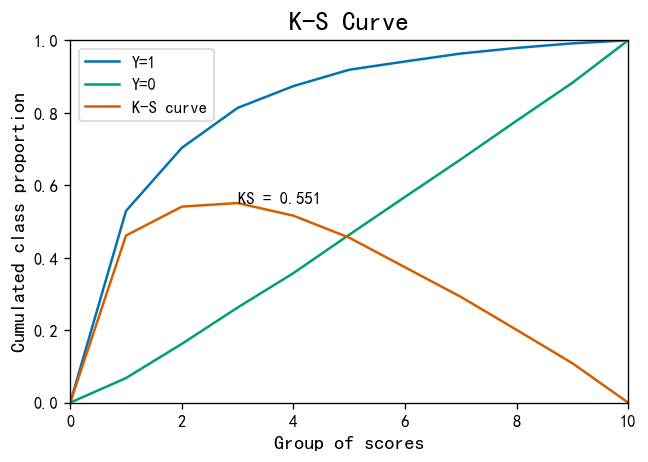

AUC: 0.8548554270245907


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\scorecardbundle\model_evaluation\ModelEvaluation.py:189: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='AUC = '+str(round(roc_auc_score(target, scores),3)),


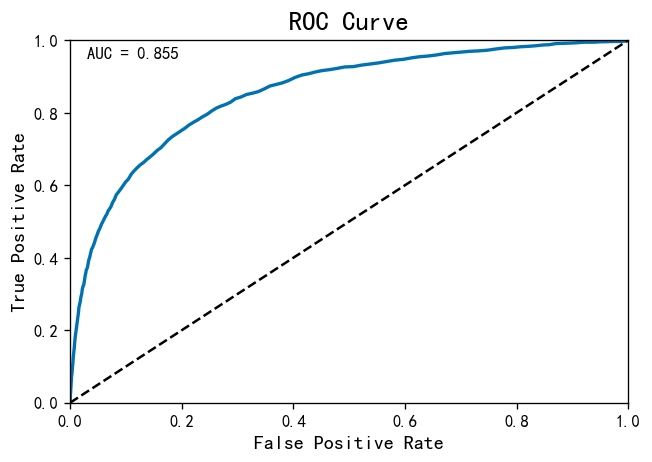

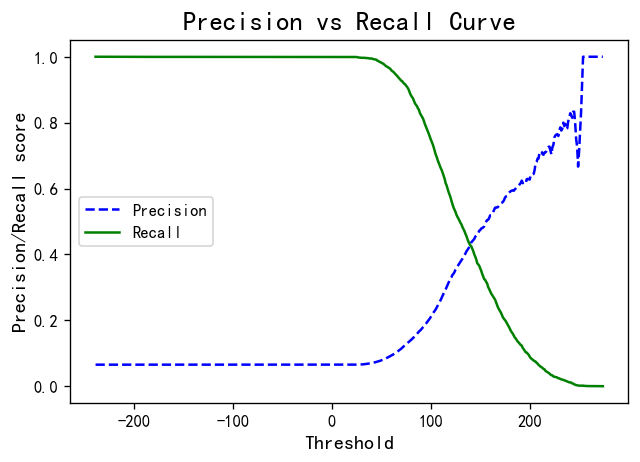

In [6]:
sc_table = model.woe_df_.copy()
result = model.predict(X_train,
                       load_scorecard=sc_table)   #评分卡应该应用在初始的特征上（即未经离散化和WOE编码的特征数据）
result_test = model.predict(X_test,
                            load_scorecard=sc_table)  # Scorecard should be applied on the original feature values
result.head()  # if model object's verbose parameter is set to False, predict will only return Total scores
# Train
evaluation = me.BinaryTargets(y_train, result['TotalScore'])
evaluation.plot_all()

# Validation
evaluation = me.BinaryTargets(y_test, result_test['TotalScore'])
evaluation.plot_all()

In [7]:
result.head()

,年龄,家属数量,月收入,负债比例,可用额度比例,普通贷款数量,不动产贷款数量,35-69天逾期次数,60-89天逾期次数,高于90天逾期次数,TotalScore
0,12.0,13.0,10.0,6.0,46.0,10.0,13.0,2.0,41.0,55.0,208.0
1,12.0,12.0,9.0,10.0,-18.0,8.0,7.0,2.0,7.0,4.0,53.0
2,-5.0,9.0,10.0,-5.0,-18.0,10.0,13.0,2.0,7.0,4.0,27.0
3,12.0,9.0,9.0,10.0,-3.0,9.0,7.0,2.0,7.0,4.0,66.0
4,17.0,9.0,7.0,10.0,-12.0,9.0,7.0,2.0,7.0,4.0,60.0


In [8]:
result_all = model.predict(X,
                       load_scorecard=sc_table)   #评分卡应该应用在初始的特征上（即未经离散化和WOE编码的特征数据）

In [9]:
result_all.head()

,年龄,家属数量,月收入,负债比例,可用额度比例,普通贷款数量,不动产贷款数量,35-69天逾期次数,60-89天逾期次数,高于90天逾期次数,TotalScore
0,12.0,12.0,9.0,22.0,26.0,9.0,26.0,36.0,7.0,4.0,163.0
1,14.0,11.0,12.0,10.0,30.0,10.0,13.0,2.0,7.0,4.0,113.0
2,14.0,9.0,12.0,10.0,20.0,12.0,13.0,24.0,7.0,40.0,161.0
3,17.0,9.0,12.0,10.0,3.0,10.0,13.0,2.0,7.0,4.0,87.0
4,12.0,9.0,7.0,10.0,30.0,9.0,7.0,24.0,7.0,4.0,119.0
